In [1]:
import numpy as np
np.random.seed(1337)
import keras
from keras.models import Sequential # 按顺序建立层
# Dense 表示全连接，激活函数，卷积层，池化层，一般神经网络
from keras.layers import Dense,Conv2D, Activation, Convolution2D, MaxPooling2D, Flatten,Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# import seaborn as sns

Using TensorFlow backend.


In [2]:
# # load_dataset
# from keras.datasets import mnist
# (X_train,y_train),(X_test,y_test) = mnist.load_data()

In [3]:
# # load data
# import pickle
# def load_file(filename):
#     with open(filename, 'rb') as fo:
#         data = pickle.load(fo, encoding='latin1')
#     return data
# dictionary = load_file("cifar-10-python.tar.gz")


## 数据介绍

1. data -- a 10000x3072 numpy array of uint8s. 
    * Each **row** of the array stores a 32x32 colour image. 
    * The first 1024 entries contain the **red channel values**, 
    * the next 1024 the **green**, and the final 1024 the **blue**. 
    * The image is stored in row-major order,so that the first 32 entries of the array are the red channel values of the first row of the image.
2. 处理数据： 
    * 图片是三维的：每张图片是高*宽为32*32的矩阵，每个矩阵点上有三个值（r,g,b）（高）
    * 目的：将数据变成32*32*（r,g,b) 的样子，然后再用imshow 画出来
    * 1.将每个图片的每一列取出来，分别为r,g,b
    * 2.将图片reshape（32，32，3）


In [4]:
# load dataset

from six.moves import cPickle
import pandas as pd
#test dataset
filename =  "cifar-10-batches-py/test_batch"
f = open(filename, 'rb')
dic =  cPickle.load(f,encoding='latin1')
f.close()
X_test = pd.DataFrame(dic["data"])
y_test = pd.DataFrame(dic["labels"])

# train dataset
filename = "cifar-10-batches-py/data_batch_1"
order = "12345"
X_train= pd.DataFrame({})
y_train = pd.DataFrame({})
for i in range(5):
    filename = filename[:-1]
    filename = filename+order[i]
    f = open(filename, 'rb')
    dic = cPickle.load(f,encoding='latin1')
    X_train = X_train.append(pd.DataFrame(dic["data"]))
    y_train= y_train.append(pd.DataFrame(dic['labels']))
    f.close()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
y_test = np.array(y_test)
y_train = np.array(y_train)
# onehot 编码
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)
print(y_train.shape)
print(y_test.shape)

(50000, 3072)
(10000, 3072)
(50000, 1)
(10000, 1)
(50000, 10)
(10000, 10)


In [5]:
# 将r,g,b 分别作为row取出, 再将它r,g,b 变成一列
X_train = np.array(X_train).reshape(50000,3,32,32)
X_test = np.array(X_test).reshape(10000,3,32,32)
r = X_train[:,0].reshape(50000,1024,1)
g = X_train[:,1].reshape(50000,1024,1)
b = X_train[:,2].reshape(50000,1024,1)
rt= X_test[:,0].reshape(10000,1024,1)
gt= X_test[:,1].reshape(10000,1024,1)
bt= X_test[:,2].reshape(10000,1024,1)
print(X_train[:,0].shape)
print(y_test.shape)

(50000, 32, 32)
(10000, 10)


(50000, 32, 32, 3)
(50000, 10)


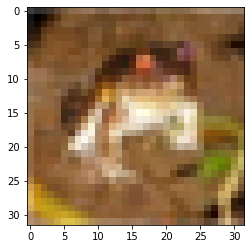

In [6]:
# 将r,g,b 合成（1024，3）， 然后拉成（32，32，3）
Xp_train = np.dstack((r,g,b)). reshape(50000,32,32,3) #hstack 是Stack arrays in sequence horizontally (column wise).
Xp_test = np.dstack((rt,gt,bt)). reshape(10000,32,32,3)
print(Xp_train.shape)
print(y_train.shape)
plt.imshow(Xp_train[0])

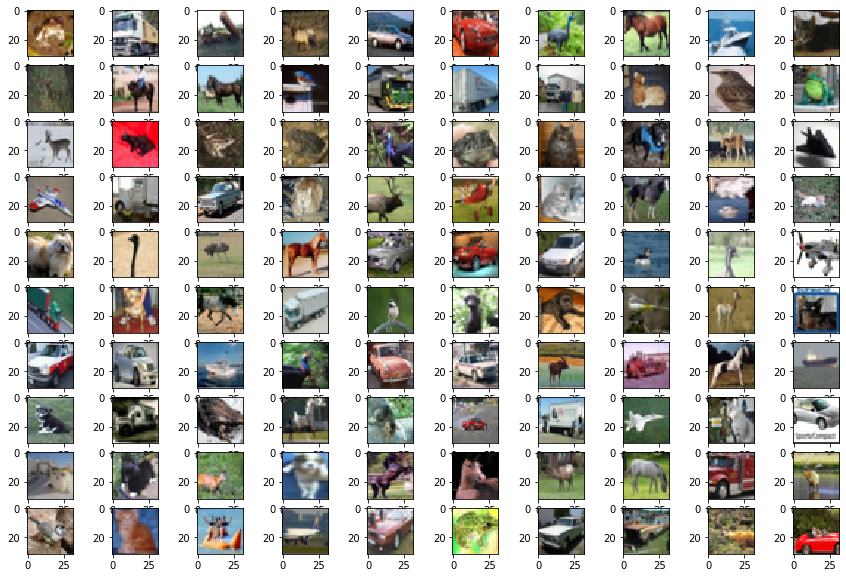

In [7]:
nrows=10
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[ii, jj]
        img_array = Xp_train[ii*ncols + jj]
        iplt.imshow(img_array)

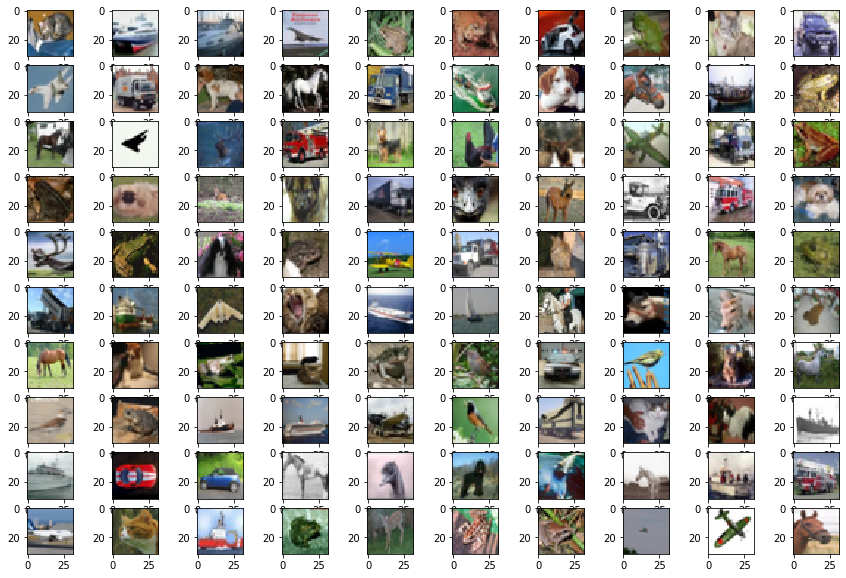

In [8]:
nrows=10
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[ii, jj]
        img_array = Xp_test[ii*ncols + jj]
        iplt.imshow(img_array)

In [9]:
model = Sequential()

In [10]:
# 卷积1
model.add(Convolution2D(
    input_shape=(32, 32, 3),
    filters=32,
    kernel_size=5,
    strides=1,
    padding='same',      # Padding method
    data_format='channels_last',
))
model.add(Activation('relu'))
# 池化层
model.add(MaxPooling2D(
    pool_size=(2,2),# 取样的时候，考虑图片的长宽
    strides=(2,2),# 取图片的间隔
    padding='same',    # Padding method,
    data_format='channels_last',
))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# 卷积2
model.add(Convolution2D(128, 5, strides=2, padding='same', data_format='channels_last'))
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2, 'same', data_format='channels_last'))

In [12]:
# 卷积3
model.add(Convolution2D(256, 5, strides=2, padding='same', data_format='channels_last'))
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2, 'same', data_format='channels_last'))

In [13]:
#Fully connected layer 1 input shape(64*7*7)=(3136),output shape (1024)
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.3))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
#Fully connected layer 1 input shape(64*7*7)=(3136),output shape (1024)
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))

In [15]:
#Fully connected layer 1 input shape(64*7*7)=(3136),output shape (1024)
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))

In [16]:
#Fully connected layer 2 input shape(64*7*7)=(3136),output shape (1024)
model.add(Dense(10))
model.add(Activation('softmax'))#用于分类的激活函数

In [17]:
#优化
# 我把有优化器从Adam 换成了rmsprop 之后准确率到了96%以上
adam = Adam(lr=1e-4)
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

In [18]:
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy']
               )


In [19]:

#X_train = X_train.reshape(X_train.shape[0], -1) / 255.   # normalize


In [20]:
# xd_train = Xp_train.astype('float32')[:30000]
# yd_train= y_train[:30000]
# x_test = Xp_test.astype('float32')

# xd_train /= 255
# x_test /= 255
# Xp_train /=255
# y_train/=255

In [21]:
Xp_train = Xp_train.astype('float32')/255
Xp_test =  Xp_test.astype('float32')/255
model.fit(Xp_train,y_train,epochs=50, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
50000/50000 [==============================] - 226s 5ms/step - loss: 1.7946 - acc: 0.3289
Epoch 2/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.4120 - acc: 0.4863
Epoch 3/50
50000/50000 [==============================] - 63s 1ms/step - loss: 1.2199 - acc: 0.5605
Epoch 4/50
50000/50000 [==============================] - 53s 1ms/step - loss: 1.0675 - acc: 0.6191
Epoch 5/50
50000/50000 [==============================] - 81s 2ms/step - loss: 0.9441 - acc: 0.6684
Epoch 6/50
50000/50000 [==============================] - 58s 1ms/step - loss: 0.8391 - acc: 0.7094
Epoch 7/50
50000/50000 [==============================] - 83s 2ms/step - loss: 0.7412 - acc: 0.7451
Epoch 8/50
50000/50000 [==============================] - 56s 1ms/step - loss: 0.6488 - acc: 0.7781
Epoch 9/50
50000/50000 [==============================] - 86s 2ms/step - loss: 0.5665 - acc: 0.8088
Epoch 10/50
50000/50000 [==========================

In [22]:
loss, accuracy = model.evaluate(Xp_test, y_test)

10000/10000 [==============================] - 15s 1ms/step


In [23]:
loss

2.9984822547912597

In [24]:
accuracy

0.6876